In [27]:
def load_model_from_minio(client, bucket_name, minio_model_path):
    """
    Load a model from MinIO storage
    
    Args:
        client: MinIO client instance
        bucket_name: Name of the MinIO bucket
        minio_model_path: Path in MinIO where model is stored
    
    Returns:
        Loaded model and class names
    """
    import tempfile
    import os
    import tensorflow as tf
    
    # Create a temporary directory to download the model
    temp_dir = tempfile.mkdtemp()
    model_file_path = os.path.join(temp_dir, 'model.keras')
    class_names_path = os.path.join(temp_dir, 'class_names.txt')
    
    # Download model file
    try:
        client.fget_object(bucket_name, f"{minio_model_path}/model.keras", model_file_path)
        client.fget_object(bucket_name, f"{minio_model_path}/class_names.txt", class_names_path)
    except Exception as e:
        print(f"Error downloading model files: {e}")
        return None, None
    
    # Load the model
    model = tf.keras.models.load_model(model_file_path)
    
    # Load class names
    with open(class_names_path, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    
    print(f"Model loaded from MinIO: {bucket_name}/{minio_model_path}")
    return model, class_names

def predict_image(model, image_path, class_names):
    """
    Make a prediction on a single image
    
    Args:
        model: Loaded model
        image_path: Path to the image
        class_names: List of class names
    
    Returns:
        Prediction results as a dictionary
    """
    import numpy as np
    from PIL import Image
    
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))  # Resize to match model input size
        img_array = np.array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        predictions = model.predict(img_array)
        
        # Get the predicted class
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        
        # Get confidence score
        confidence = predictions[0][predicted_class_idx]
        
        # Format all class probabilities
        class_probabilities = {}
        for i, class_name in enumerate(class_names):
            class_probabilities[class_name] = float(predictions[0][i])
        
        return {
            'predicted_class': predicted_class,
            'confidence': float(confidence),
            'class_probabilities': class_probabilities
        }
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None

def predict_batch(model, image_paths, class_names):
    """
    Make predictions on a batch of images
    
    Args:
        model: Loaded model
        image_paths: List of paths to images
        class_names: List of class names
    
    Returns:
        List of prediction results
    """
    results = []
    for path in image_paths:
        result = predict_image(model, path, class_names)
        if result:
            result['image_path'] = path
            results.append(result)
    return results
    
# Function to evaluate model on a dataset matching your class directory structure
def evaluate_model_on_dataset(model, data_directory, class_names):
    """
    Evaluate model on a dataset
    
    Args:
        model: Loaded model
        data_directory: Directory containing the dataset
        class_names: List of class names
    
    Returns:
        Evaluation metrics
    """
    import os
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    from PIL import Image
    
    # First, let's find all the class directories in the data directory
    class_dirs = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]
    print(f"Found class directories: {class_dirs}")
    print(f"Model class names: {class_names}")
    
    # Create mappings for class directories to indices
    # For directories like 'class_0_adipose', we need to extract the index (0)
    dir_to_idx = {}
    for class_dir in class_dirs:
        if class_dir.startswith('class_'):
            try:
                # Extract the index number from the directory name
                idx = int(class_dir.split('_')[1])
                dir_to_idx[class_dir] = idx
            except (IndexError, ValueError):
                print(f"Warning: Could not parse index from {class_dir}, skipping")
    
    print(f"Directory to index mapping: {dir_to_idx}")
    
    # Collect images and their true labels
    images = []
    true_labels = []
    image_paths = []
    
    print(f"Looking for test images in {data_directory}")
    
    for class_dir in class_dirs:
        class_path = os.path.join(data_directory, class_dir)
        if class_dir in dir_to_idx:
            class_idx = dir_to_idx[class_dir]
            print(f"Processing class directory: {class_dir} (index: {class_idx})")
            
            test_count = 0
            for image_file in os.listdir(class_path):
                if image_file.startswith('test_img_') and image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_path, image_file)
                    try:
                        img = Image.open(image_path).convert('RGB')
                        img = img.resize((224, 224))  # Resize to match model input size
                        img_array = np.array(img) / 255.0  # Normalize
                        
                        images.append(img_array)
                        true_labels.append(class_idx)
                        image_paths.append(image_path)
                        test_count += 1
                    except Exception as e:
                        print(f"Error loading {image_path}: {e}")
            
            print(f"  Found {test_count} test images for class {class_dir}")
    
    print(f"Total test images found: {len(images)}")
    
    if len(images) == 0:
        print("No test images found for evaluation.")
        return None
    
    # Convert to numpy arrays
    X = np.array(images)
    y_true = np.array(true_labels)
    
    # Make predictions without progress bar
    y_pred_probs = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Evaluation Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    
    # Print detailed classification report
    print("\nClassification Report:")
    # Use class_names for the report if they match the number of classes
    if len(class_names) == len(np.unique(y_true)):
        target_names = class_names
    else:
        # Otherwise create generic class names based on indices
        target_names = [f"Class {i}" for i in range(len(np.unique(y_true)))]
    
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Return incorrect predictions for analysis
    incorrect_idx = np.where(y_pred != y_true)[0]
    incorrect_predictions = []
    
    for idx in incorrect_idx:
        incorrect_predictions.append({
            'image_path': image_paths[idx],
            'true_class': f"Class {y_true[idx]}",
            'predicted_class': f"Class {y_pred[idx]}",
            'confidence': float(y_pred_probs[idx][y_pred[idx]])
        })
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'incorrect_predictions': incorrect_predictions
    }

# Helper function to count test images by class
def count_test_images(data_directory):
    """
    Count and show test images in each class directory
    
    Args:
        data_directory: Directory containing the dataset
    """
    import os
    
    print(f"Scanning for test images in: {data_directory}")
    total_count = 0
    
    for class_dir in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_dir)
        if os.path.isdir(class_path):
            test_images = [f for f in os.listdir(class_path) 
                          if f.startswith('test_img_') and 
                          f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            print(f"Class: {class_dir} - Found {len(test_images)} test images")
            if test_images:
                print(f"  Sample test images: {', '.join(test_images[:3])}")
            total_count += len(test_images)
    
    print(f"Total test images found: {total_count}")


def visualize_predictions(model, image_paths, class_names, num_images=5):
    """
    Visualize model predictions on a set of images
    
    Args:
        model: Loaded model
        image_paths: List of paths to images
        class_names: List of class names
        num_images: Number of images to visualize
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image
    
    # Select a subset of images if needed
    if len(image_paths) > num_images:
        image_paths = image_paths[:num_images]
    
    # Set up the plot
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    if len(image_paths) == 1:
        axes = [axes]
    
    for i, image_path in enumerate(image_paths):
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize((224, 224))  # Resize for the model
        img_array = np.array(img_resized) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx]
        
        # Display the image
        axes[i].imshow(np.array(img))
        axes[i].set_title(f"Pred: {predicted_class}\nConf: {confidence:.2f}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [2]:
# Import required libraries for model building
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from minio import Minio
from utils.config import MINIO_ENDPOINT, MINIO_SECURE

def get_minio_client() -> Minio:
    """Initialize and return a MinIO client."""
    return Minio(
        endpoint=MINIO_ENDPOINT,
        access_key=os.getenv("MINIO_ACCESS_KEY"),
        secret_key=os.getenv("MINIO_SECRET_KEY"),
        session_token=os.getenv("MINIO_SESSION_TOKEN"),
        secure=MINIO_SECURE
    )


client = get_minio_client()


2025-03-30 15:56:58.136524: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 15:56:58.219679: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 15:56:58.291242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743339418.356306  195526 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743339418.376013  195526 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743339418.512570  195526 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
# 1. Load model from MinIO
client = get_minio_client()
bucket_name = "innov-test-bucket"
minio_model_path = "trained_models/medmnist_model"
model, class_names = load_model_from_minio(client, bucket_name, minio_model_path)

Model loaded from MinIO: innov-test-bucket/trained_models/medmnist_model


In [28]:
# 2. Make prediction on a single image
single_image_path = "./downloaded_data/class_0_adipose/test_img_7.png"
result = predict_image(model, single_image_path, class_names)
print(f"Prediction for {single_image_path}:")
print(f"  Predicted class: {result['predicted_class']}")
print(f"  Confidence: {result['confidence']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for ./downloaded_data/class_0_adipose/test_img_7.png:
  Predicted class: 8 colorectal adenocarcinoma epithelium
  Confidence: 0.9994


Found class directories: ['class_6_normal_colon_mucosa', 'class_8_colorectal_adenocarcinoma_epithelium', 'class_1_background', 'class_0_adipose', 'class_2_debris', 'class_7_cancer-associated_stroma', 'class_3_lymphocytes', 'class_4_mucus', 'class_5_smooth_muscle']
Model class names: ['0 adipose', '1 background', '2 debris', '3 lymphocytes', '4 mucus', '5 smooth muscle', '6 normal colon mucosa', '7 cancer-associated stroma', '8 colorectal adenocarcinoma epithelium']
Directory to index mapping: {'class_6_normal_colon_mucosa': 6, 'class_8_colorectal_adenocarcinoma_epithelium': 8, 'class_1_background': 1, 'class_0_adipose': 0, 'class_2_debris': 2, 'class_7_cancer-associated_stroma': 7, 'class_3_lymphocytes': 3, 'class_4_mucus': 4, 'class_5_smooth_muscle': 5}
Looking for test images in ./downloaded_data/
Processing class directory: class_6_normal_colon_mucosa (index: 6)
  Found 11 test images for class class_6_normal_colon_mucosa
Processing class directory: class_8_colorectal_adenocarcinoma

/home/george/.cache/pypoetry/virtualenvs/humaine-swarm-IeHX0o3Z-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/george/.cache/pypoetry/virtualenvs/humaine-swarm-IeHX0o3Z-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/george/.cache/pypoetry/virtualenvs/humaine-swarm-IeHX0o3Z-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

Evaluation Results:
  Accuracy: 0.1800
  Precision: 0.0421
  Recall: 0.1800
  F1 Score: 0.0641

Classification Report:
                                        precision    recall  f1-score   support

                             0 adipose       0.00      0.00      0.00        26
                          1 background       0.00      0.00      0.00         8
                              2 debris       0.00      0.00      0.00         5
                         3 lymphocytes       0.00      0.00      0.00         9
                               4 mucus       0.00      0.00      0.00        15
                       5 smooth muscle       0.29      0.40      0.33         5
                 6 normal colon mucosa       0.00      0.00      0.00        11
            7 cancer-associated stroma       0.00      0.00      0.00         5
8 colorectal adenocarcinoma epithelium       0.17      1.00      0.30        16

                              accuracy                           0.18       100

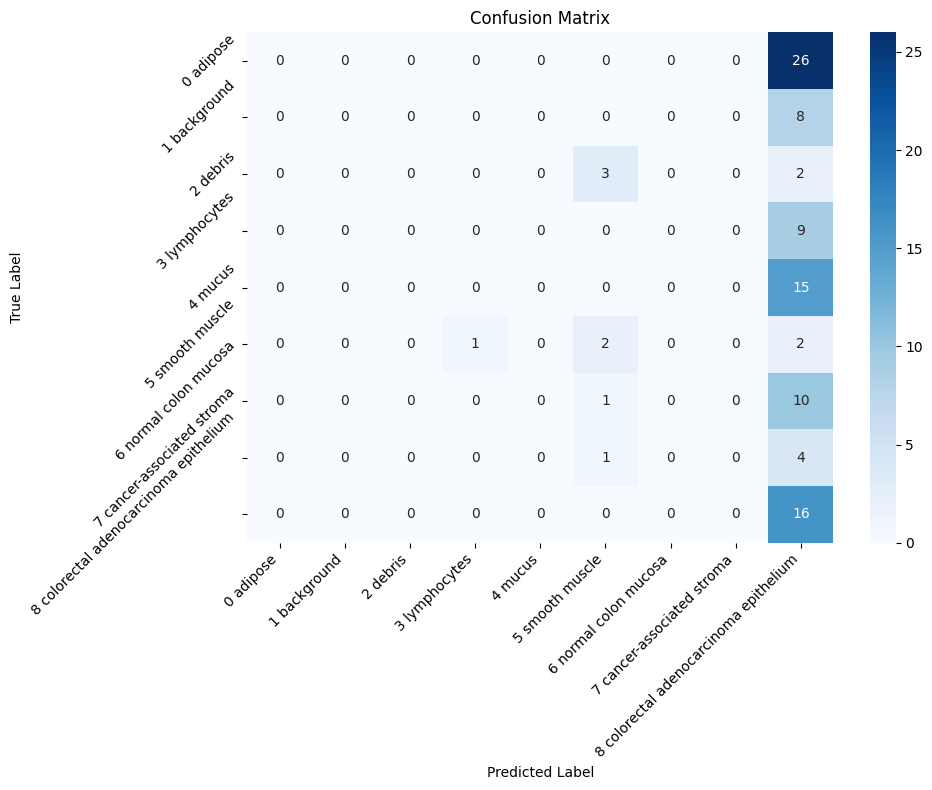

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


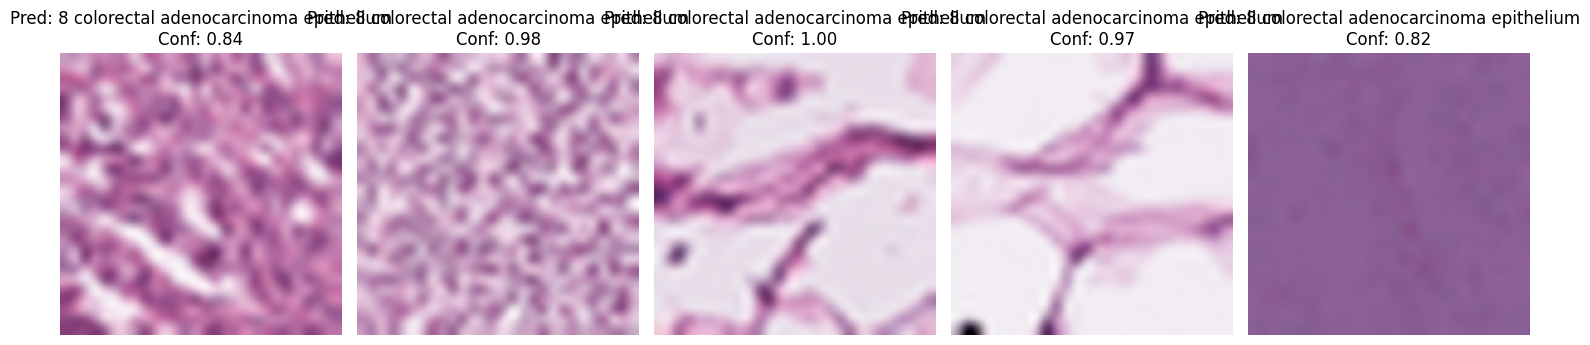

In [29]:
# 3. Evaluate model on a test dataset
local_data_directory = "./downloaded_data/"
evaluation_results = evaluate_model_on_dataset(model, local_data_directory, class_names)

# 4. Visualize some predictions
import os
import random

# Collect some random test images
test_images = []
for root, dirs, files in os.walk(local_data_directory):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')) and file.startswith('test_'):
            test_images.append(os.path.join(root, file))

# Randomly select a few images
if test_images:
    random_test_images = random.sample(test_images, min(5, len(test_images)))
    visualize_predictions(model, random_test_images, class_names)